<a href="https://colab.research.google.com/github/zhubiii/PogoDrone/blob/main/twoDPogoDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install JSAnimation
!sudo apt-get install texlive-latex-recommended 
!sudo apt install texlive-latex-extra
!sudo apt install dvipng
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.2018

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML
from numpy.random import default_rng
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('figure', figsize=(10,12))
plt.rc('legend', fontsize=20)
plt.rc('axes', titlesize="large")
plt.rc("axes", labelsize="large")

In [ ]:
# state: [height, velocity]
state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
m = 0.05
I = 0.001
g = 9.8
k = 400
b = 1.0
l0 = 0.05 # rest length of the spring
lmin = 0.01 # minimum length of the spring
delta_t = 0.001
hold_method = 3 # 1: hover; 2: drop and move back; 3: drop and spring back
state_des = np.array([0.2, 0.8, 0.0, 0.0, 0.0, 0.0])
minimum_h = 0.2 # the height at which the robot activates
t_final = 18

# logs
log_u = [np.array([0.0, 0.0])]
log_x = [state[0]]
log_y = [state[1]]
log_theta = [state[2]]
log_spring_force = [0.0]
log_spring_length = [l0]

log_t = [0.0]
noise_level = 0.02
noise_level_spring = 0.5
rng = default_rng()

In [ ]:
# A-matrix
p1 = np.array([-0.032, 0])
p2 = np.array([0.032, 0])
e2 = np.array([0, 1])
A = np.array([[1, 1], [np.cross(p1, e2), np.cross(p2, e2)]])
A_full = np.array([[0, 0], [1, 1], [np.cross(p1, e2), np.cross(p2, e2)]])

In [ ]:
def rot2D(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [ ]:
def distance2D(pt1, pt2):
    return np.linalg.norm(pt1-pt2)

In [ ]:
# helper variable
free_falling = False
old_delta_x = 0

def step(state, state_d):
    global free_falling
    global old_delta_x
    if hold_method == 1:
        u = controller(state, state_d)
        wrench = A_full.dot(u)
        theta = state[2]
        f_W = rot2D(theta).dot(wrench[:2])
        dstate = np.array([state[3], state[4], state[5], f_W[0]/m, f_W[1]/m-g, wrench[2]/I])
        state = integral(state, dstate, delta_t)
    elif hold_method == 2:
        if free_falling: 
            if state[1] >= minimum_h:
                # if not low enough in free fall, 
                # free fall
                u = np.array([0, 0])
                dstate = np.array([state[3], state[4], state[5], 0, -g, 0])
                state = integral(state, dstate, delta_t)
            else:
                free_falling = False
                u = controller(state, state_d)
                wrench = A_full.dot(u)
                theta = state[2]
                f_W = rot2D(theta).dot(wrench[:2])
                dstate = np.array([state[3], state[4], state[5], f_W[0]/m, f_W[1]/m-g, wrench[2]/I])
                state = integral(state, dstate, delta_t)
        elif distance2D(state[:2], state_d[:2]) < 0.05 and np.abs(state[5]) < 0.1 and np.linalg.norm(state[3:5])<0.05:
            # if high enough and not oscillating much in hover, 
            # freely fall
            free_falling = True
            u = np.array([0, 0])
            dstate = np.array([state[3], state[4], state[5], 0, -g, 0])
            state = integral(state, dstate, delta_t)
        else:
            u = controller(state, state_d)
            wrench = A_full.dot(u)
            theta = state[2]
            f_W = rot2D(theta).dot(wrench[:2])
            dstate = np.array([state[3], state[4], state[5], f_W[0]/m, f_W[1]/m-g, wrench[2]/I])
            state = integral(state, dstate, delta_t)
    elif hold_method == 3:
        # calculate the distance from the CoM to the ground along the spring
        spring_length = state[1]/np.cos(state[2])
        if spring_length <= l0:
            log_spring_length.append(spring_length)
        else:
            log_spring_length.append(l0)

        # the spring cannot compress anymore 
        if spring_length <= lmin and state[4] < 0:
            # whether the propellers are active or not, activate them
            free_falling = False
            delta_x = spring_length - l0
            ddelta_x = (delta_x - old_delta_x)/delta_t
            old_delta_x = delta_x
            spring_force = (-k*delta_x - b*ddelta_x)*(1+noise_level_spring*rng.standard_normal())
            log_spring_force.append(spring_force)
            fs_W = rot2D(state[2]*(1+5*noise_level_spring*rng.standard_normal())).dot(np.array([0, spring_force]))
            u = controller(state, state_d)
            wrench = A_full.dot(u)
            theta = state[2]
            f_W = rot2D(theta).dot(wrench[:2])
            # reverse the direction of motion in y and lose energy
            state = np.array([state[0], state[1], state[2], state[3], -0.2*state[4], state[5]])
            # print("cannot compress anymore", state[4])
            dstate = np.array([state[3], state[4], state[5], (fs_W[0]+f_W[0])/m, (fs_W[1]+f_W[1])/m-g, wrench[2]/I])
            state = integral(state, dstate, delta_t)
            # print(state[4])
        else:
            if free_falling:
                if spring_length > l0:
                    # spring is uncompressed, and going down, keep going down
                    # print("uncompressed and falling")
                    u = controller(state, state_d, True)
                    wrench = A_full.dot(u)
                    theta = state[2]
                    f_W = rot2D(theta).dot(wrench[:2])
                    dstate = np.array([state[3], state[4], state[5], f_W[0]/m, f_W[1]/m-g, wrench[2]/I])
                    state = integral(state, dstate, delta_t)
                    log_spring_force.append(0)
                else:
                    # spring is compressed, and going down, keep going down and have
                    # the spring do the spring thing
                    # print("compressed and falling")
                    u = controller(state, state_d, True)
                    wrench = A_full.dot(u)
                    theta = state[2]
                    f_W = rot2D(theta).dot(wrench[:2])
                    delta_x = spring_length - l0
                    ddelta_x = (delta_x - old_delta_x)/delta_t
                    old_delta_x = delta_x
                    
                    spring_force = (-k*delta_x - b*ddelta_x)
                    log_spring_force.append(spring_force)
                    fs_W = rot2D(state[2]*(1+5*noise_level_spring*rng.standard_normal())).dot(np.array([0, spring_force]))

                    dstate = np.array([state[3], state[4], state[5], (f_W[0]+fs_W[0])/m, (f_W[1]+fs_W[1])/m-g, wrench[2]/I])
                    state = integral(state, dstate, delta_t)
                    if state[1] < minimum_h:
                        free_falling = False
            else:
                if spring_length > l0:
                    # spring is uncompressed, and going up, activate the prop to hover
                    # print("uncompressed and propelling")
                    u = controller(state, state_d)
                    wrench = A_full.dot(u)
                    theta = state[2]
                    f_W = rot2D(theta).dot(wrench[:2])
                    dstate = np.array([state[3], state[4], state[5], f_W[0]/m, f_W[1]/m-g, wrench[2]/I])
                    state = integral(state, dstate, delta_t)
                    if distance2D(state[:2], state_d[:2]) < 0.03 and np.abs(state[5]) < 0.05 and np.linalg.norm(state[3:5])<0.01:
                        free_falling = True
                    log_spring_force.append(0)

                else:
                    # spring is compressed, and going up, activate the prop to hover 
                    # and have the spring do the spring thing
                    # print("compressed and propelling")
                    u = controller(state, state_d)
                    delta_x = spring_length - l0
                    ddelta_x = (delta_x - old_delta_x)/delta_t
                    old_delta_x = delta_x
                    
                    spring_force = (-k*delta_x - b*ddelta_x)
                    log_spring_force.append(spring_force)
                    fs_W = rot2D(state[2]*(1+5*noise_level_spring*rng.standard_normal())).dot(np.array([0, spring_force]))
                    u = controller(state, state_d)
                    wrench = A_full.dot(u)
                    theta = state[2]
                    f_W = rot2D(theta).dot(wrench[:2])
                    dstate = np.array([state[3], state[4], state[5], (f_W[0]+fs_W[0])/m, (f_W[1]+fs_W[1])/m-g, wrench[2]/I])
                    state = integral(state, dstate, delta_t)
    
    log_x.append(state[0])
    log_y.append(state[1])
    log_theta.append(state[2])
    log_u.append(u)
    return state

In [ ]:
def integral(state, dstate, dt):
    state += dstate*dt
    if state[2] <= -np.pi:
        state[2] += 2*np.pi
    elif state[2] > np.pi:
        state[2] -= 2*np.pi
    return state

In [ ]:
Kpx = 1.0
Kdx = 3.0
Kpy = 1.5
Kdy = 3.0
Ktheta = 20.0
Komega = 10.0
def controller(state, state_d, att_only=False):
    x, y, theta, dx, dy, dtheta = state
    err = state_d - state
    
    # linear feedback on position
    des_f = m*np.array([Kpx*err[0]+Kdx*err[3], 
                        Kpy*err[1]+Kdy*err[4]+g])
    R = rot2D(theta)
    f_y = R[:,1].dot(des_f)

    theta_d = np.arctan2(-des_f[0], des_f[1])
    err_theta = theta_d - theta
    err_dtheta = state_d[5] - state[5]
    if err_theta <= -np.pi:
        err_theta += 2*np.pi
    elif err_theta > np.pi:
        err_theta -= 2*np.pi
    
    des_tau = I*(Ktheta*err_theta + Komega*err_dtheta)
    if att_only:
        f_y = 0
    u = np.linalg.inv(A).dot(np.array([f_y, des_tau]))
    # if True in [np.isnan(i) for i in u]:
    #     print(np.array([f_y, des_tau]), des_f, theta_d, state, state_d)

    return np.array([max(i*(1+noise_level*rng.standard_normal()), 0) for i in u])
    # return u

In [ ]:
def simulate(state, state_des):
    for i in range(int(t_final/delta_t)):
        log_t.append(i*delta_t)
        state = step(state, state_des)

In [ ]:
def clear_logs():
    global free_falling
    global old_delta_x
    free_falling = False
    old_delta_x = 0
    log_spring_force.clear()
    log_spring_length.clear()
    log_t.clear()
    log_theta.clear()
    log_u.clear()
    log_x.clear()
    log_y.clear()

In [ ]:
# test different noise level
iteration = 20
noise_levels = [i*0.05 for i in range(21)]
log_u_nospring_sum_iterative = []
log_u_spring_sum_iterative = []
log_u_nospring_sum = []
log_u_spring_sum = []
log_u = []
for i in range(iteration):
    log_u_nospring_sum = []
    log_u_spring_sum = []
    for noise in noise_levels:
        print("iteration {} out of {}, noise leve={}".format(i, iteration, noise))
        noise_level = noise
        noise_level_spring = noise*5
        hold_method = 1
        simulate(state, state_des)
        log_u_nospring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])

        hold_method = 3
        simulate(state, state_des)
        while(True in [np.isnan(i[0]) for i in log_u]):
            print("nan problem encountered")
            clear_logs()
            state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
            simulate(state, state_des)

        log_u_spring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
    log_u_nospring_sum_iterative.append(log_u_nospring_sum)
    log_u_spring_sum_iterative.append(log_u_spring_sum)

noise_level = 0.02
noise_level_spring = 0.1

iteration 0 out of 20, noise leve=0.0
iteration 0 out of 20, noise leve=0.05
iteration 0 out of 20, noise leve=0.1
iteration 0 out of 20, noise leve=0.15000000000000002
iteration 0 out of 20, noise leve=0.2
iteration 0 out of 20, noise leve=0.25
iteration 0 out of 20, noise leve=0.30000000000000004
iteration 0 out of 20, noise leve=0.35000000000000003
iteration 0 out of 20, noise leve=0.4
iteration 0 out of 20, noise leve=0.45
iteration 0 out of 20, noise leve=0.5
iteration 0 out of 20, noise leve=0.55
iteration 0 out of 20, noise leve=0.6000000000000001
iteration 0 out of 20, noise leve=0.65
iteration 0 out of 20, noise leve=0.7000000000000001
iteration 0 out of 20, noise leve=0.75
iteration 0 out of 20, noise leve=0.8
iteration 0 out of 20, noise leve=0.8500000000000001
iteration 0 out of 20, noise leve=0.9
iteration 0 out of 20, noise leve=0.9500000000000001
iteration 0 out of 20, noise leve=1.0
iteration 1 out of 20, noise leve=0.0
iteration 1 out of 20, noise leve=0.05
iteration 1

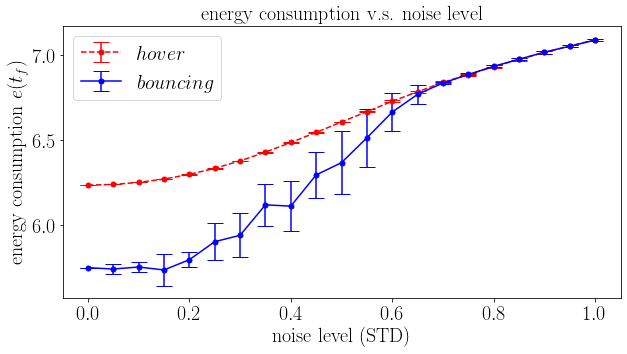

In [ ]:
log_u_nospring_sum_iterative = np.array(log_u_nospring_sum_iterative)
log_u_spring_sum_iterative = np.array(log_u_spring_sum_iterative)
log_u_nospring_sum_mean = np.mean(log_u_nospring_sum_iterative, axis=0)
log_u_spring_sum_mean = np.mean(log_u_spring_sum_iterative, axis=0)
log_u_nospring_sum_std = np.std(log_u_nospring_sum_iterative, axis=0)
log_u_spring_sum_std = np.std(log_u_spring_sum_iterative, axis=0)

fig, ax = plt.subplots()

ax.set_xlabel('noise level (STD)', fontsize=20)
ax.set_ylabel('energy consumption $e(t_f)$', fontsize=20)
ax.set_title('energy consumption v.s. noise level', fontsize=20)
ax.errorbar(noise_levels, log_u_nospring_sum_mean, yerr=log_u_nospring_sum_std, label='$hover$', capsize=8, markersize="5", fmt='r--o')
ax.errorbar(noise_levels, log_u_spring_sum_mean, yerr=log_u_spring_sum_std, capsize=8, markersize="5", fmt='bo-', label='$bouncing$')
ax.legend()
plt.savefig('simnl.pdf')

In [ ]:
iteration = 20
# test different spring constant
k_vals = [50*(i+1) for i in range(31)]
log_u_nospring_sum_iterative_k = []
log_u_spring_sum_iterative_k = []
log_u_nospring_sum = []
log_u_spring_sum = []
log_u = []
for i in range(iteration):
    log_u_nospring_sum = []
    log_u_spring_sum = []
    for k in k_vals:
        print("iteration {} out of {}, k={}".format(i, iteration, k))
        hold_method = 1
        simulate(state, state_des)
        log_u_nospring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])

        hold_method = 3
        simulate(state, state_des)
        while(True in [np.isnan(i[0]) for i in log_u]):
            print("nan problem encountered")
            clear_logs()
            state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
            simulate(state, state_des)

        log_u_spring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
    log_u_nospring_sum_iterative_k.append(log_u_nospring_sum)
    log_u_spring_sum_iterative_k.append(log_u_spring_sum)

k = 400
b = 1.0

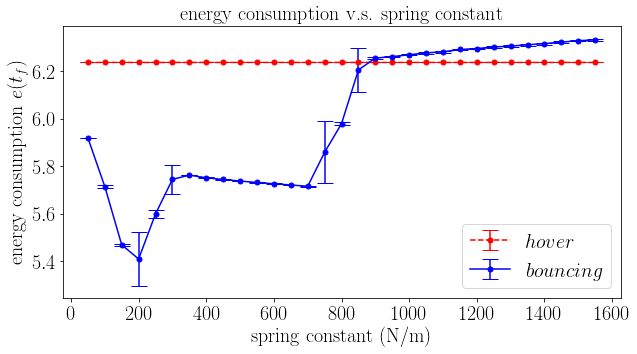

In [ ]:
log_u_nospring_sum_iterative_k = np.array(log_u_nospring_sum_iterative_k)
log_u_spring_sum_iterative_k = np.array(log_u_spring_sum_iterative_k)
log_u_nospring_sum_mean_k = np.mean(log_u_nospring_sum_iterative_k, axis=0)
log_u_spring_sum_mean_k = np.mean(log_u_spring_sum_iterative_k, axis=0)
log_u_nospring_sum_std_k = np.std(log_u_nospring_sum_iterative_k, axis=0)
log_u_spring_sum_std_k = np.std(log_u_spring_sum_iterative_k, axis=0)

fig, ax = plt.subplots()

# ax.grid()
ax.set_xlabel('spring constant (N/m)', fontsize=20)
ax.set_ylabel('energy consumption $e(t_f)$', fontsize=20)
ax.set_title('energy consumption v.s. spring constant', fontsize=20)
ax.errorbar(k_vals, log_u_nospring_sum_mean_k, yerr=log_u_nospring_sum_std_k, label='$hover$', capsize=8, markersize="5", fmt='r--o')
ax.errorbar(k_vals, log_u_spring_sum_mean_k, yerr=log_u_spring_sum_std_k, label='$bouncing$', capsize=8, markersize="5", fmt='b-o')
ax.legend()
plt.savefig('simsc.pdf')

In [ ]:
iteration = 20
# test different damping factor
b_vals = [i*0.5 for i in range(21)]
log_u_nospring_sum_iterative_b = []
log_u_spring_sum_iterative_b = []
log_u_nospring_sum = []
log_u_spring_sum = []
log_u = []
clear_logs()
for i in range(iteration):
    log_u_nospring_sum = []
    log_u_spring_sum = []
    for b in b_vals:
        print("iteration {} out of {}, b={}".format(i, iteration, b))
        hold_method = 1
        simulate(state, state_des)
        log_u_nospring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])

        hold_method = 3
        simulate(state, state_des)
        while(True in [np.isnan(i[0]) for i in log_u]):
            print("nan problem encountered")
            clear_logs()
            state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
            simulate(state, state_des)

        log_u_spring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
    log_u_nospring_sum_iterative_b.append(log_u_nospring_sum)
    log_u_spring_sum_iterative_b.append(log_u_spring_sum)

k = 400
b = 1.0

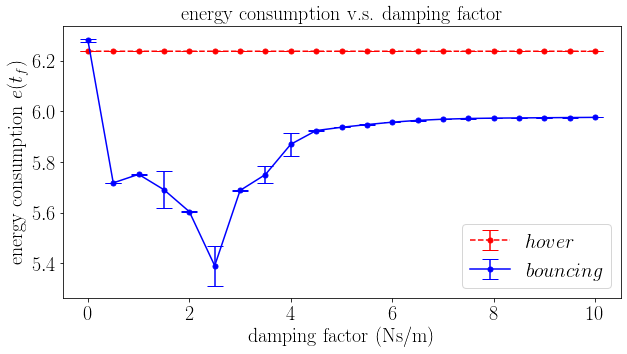

In [ ]:
log_u_nospring_sum_iterative_b = np.array(log_u_nospring_sum_iterative_b)
log_u_spring_sum_iterative_b = np.array(log_u_spring_sum_iterative_b)
log_u_nospring_sum_mean_b = np.mean(log_u_nospring_sum_iterative_b, axis=0)
log_u_spring_sum_mean_b = np.mean(log_u_spring_sum_iterative_b, axis=0)
log_u_nospring_sum_std_b = np.std(log_u_nospring_sum_iterative_b, axis=0)
log_u_spring_sum_std_b = np.std(log_u_spring_sum_iterative_b, axis=0)

fig, ax = plt.subplots()

ax.set_xlabel('damping factor (Ns/m)', fontsize=20)
ax.set_ylabel('energy consumption $e(t_f)$', fontsize=20)
ax.set_title('energy consumption v.s. damping factor', fontsize=20)
ax.errorbar(b_vals, log_u_nospring_sum_mean_b, yerr=log_u_nospring_sum_std_b, label='$hover$', capsize=8, markersize="5", fmt='r--o')
ax.errorbar(b_vals, log_u_spring_sum_mean_b, yerr=log_u_spring_sum_std_b, label='$bouncing$', capsize=8, markersize="5", fmt='b-o')
ax.legend()
plt.savefig('simdf.pdf')

In [ ]:
iteration = 20
# test different desired height
h_vals = [0.3*i+0.3 for i in range(21)]
log_u_nospring_sum_iterative_h = []
log_u_spring_sum_iterative_h = []
log_u_nospring_sum = []
log_u_spring_sum = []
log_u = []
clear_logs()
for i in range(iteration):
    log_u_nospring_sum = []
    log_u_spring_sum = []
    for h in h_vals:
        state_des = [0.2, h, 0.0, 0.0, 0.0, 0.0]
        print("iteration {} out of {}, h={}".format(i, iteration, h))
        hold_method = 1
        simulate(state, state_des)
        log_u_nospring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])

        hold_method = 3
        simulate(state, state_des)
        while(True in [np.isnan(i[0]) for i in log_u]):
            print("nan problem encountered")
            clear_logs()
            state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
            simulate(state, state_des)

        log_u_spring_sum.append(sum([np.linalg.norm(u) for u in log_u])*delta_t)
        clear_logs()
        state = np.array([0.0, 0.3, 0.0, 0.0, 0.0, 0.0])
    log_u_nospring_sum_iterative_h.append(log_u_nospring_sum)
    log_u_spring_sum_iterative_h.append(log_u_spring_sum)

state_des = [0.2, 0.8, 0.0, 0.0, 0.0, 0.0]

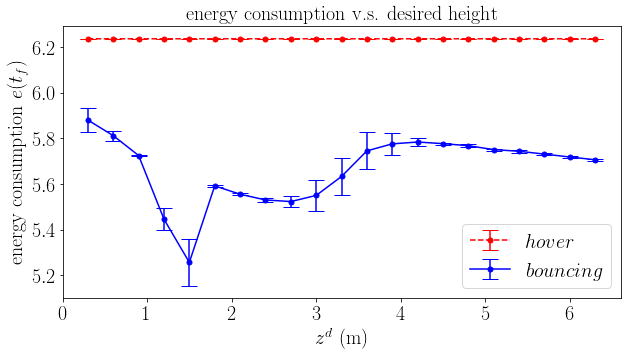

In [ ]:
log_u_nospring_sum_iterative_h = np.array(log_u_nospring_sum_iterative_h)
log_u_spring_sum_iterative_h = np.array(log_u_spring_sum_iterative_h)
log_u_nospring_sum_mean_h = np.mean(log_u_nospring_sum_iterative_h, axis=0)
log_u_spring_sum_mean_h = np.mean(log_u_spring_sum_iterative_h, axis=0)
log_u_nospring_sum_std_h = np.std(log_u_nospring_sum_iterative_h, axis=0)
log_u_spring_sum_std_h = np.std(log_u_spring_sum_iterative_h, axis=0)

fig, ax = plt.subplots()

# ax.grid()
ax.set_xlabel('$z^d$ (m)', fontsize=20)
ax.set_ylabel('energy consumption $e(t_f)$', fontsize=20)
ax.set_title('energy consumption v.s. desired height', fontsize=20)
ax.errorbar(h_vals, log_u_nospring_sum_mean_h, yerr=log_u_nospring_sum_std_h, label='$hover$', capsize=8, markersize="5", fmt='r--o')
ax.errorbar(h_vals, log_u_spring_sum_mean_h, yerr=log_u_spring_sum_std_h, label='$bouncing$', capsize=8, markersize="5", fmt='b-o')
ax.legend()
plt.savefig('simdh.pdf')

In [ ]:
simulate(state, state_des)

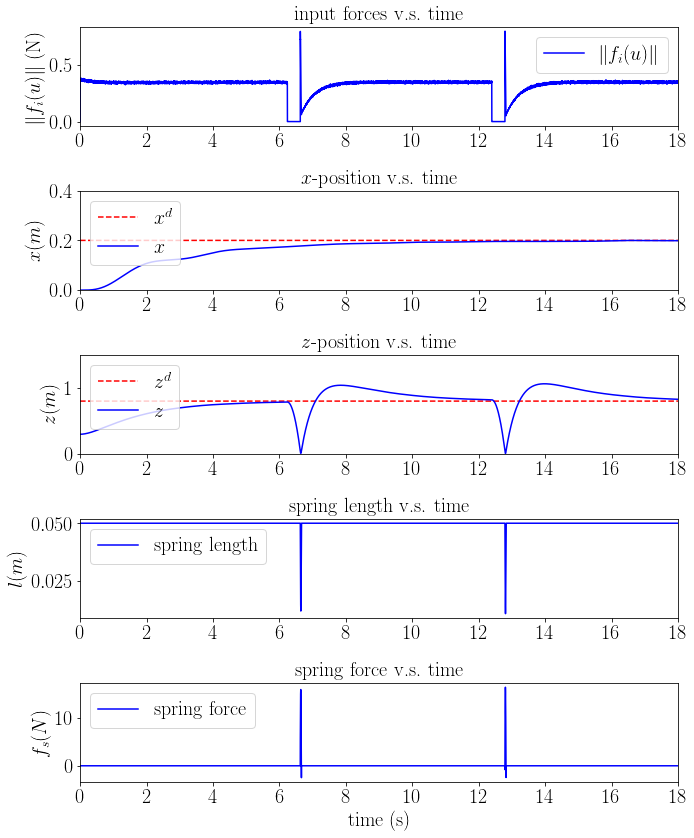

In [ ]:
log_u = np.array(log_u)
fig = plt.figure()

ax1 = fig.add_subplot(511)
# ax1.grid()
plt.xlim([0.0, 18.0])
ax1.set_ylabel('$\Vert f_i(u)\Vert$ (N)', fontsize=20)
ax1.set_title('input forces v.s. time', fontsize=20)
ax1.plot(log_t, np.linalg.norm(log_u, axis=1), 'b', label='$\Vert f_i(u)\Vert$')
ax1.legend()

ax2 = fig.add_subplot(512)
# ax2.grid()
plt.xlim([0.0, 18.0])
plt.ylim([0.0, 0.4])
ax2.set_ylabel('$x (m)$', fontsize=20)
ax2.set_title('$x$-position v.s. time', fontsize=20)
ax2.plot(log_t, [0.2]*len(log_t), '--r', label='$x^d$')
ax2.plot(log_t, log_x, 'b', label='$x$')
ax2.legend()

ax3 = fig.add_subplot(513)
# ax2.grid()
plt.xlim([0.0, 18.0])
plt.ylim([0.0, 1.5])
ax3.set_ylabel('$z (m)$', fontsize=20)
ax3.set_title('$z$-position v.s. time', fontsize=20)
ax3.plot(log_t, [0.8]*len(log_t), '--r', label='$z^d$')
ax3.plot(log_t, log_y, 'b', label='$z$')
ax3.legend()

if hold_method == 3:
    ax4 = fig.add_subplot(514)
    # ax4.grid()
    plt.xlim([0.0, 18.0])
    ax4.set_ylabel('$l(m)$', fontsize=20)
    ax4.set_title('spring length v.s. time', fontsize=20)
    ax4.plot(log_t, log_spring_length, 'b', label='spring length')
    ax4.legend()

    ax5 = fig.add_subplot(515)
    # ax5.grid()
    plt.xlim([0.0, 18.0])
    ax5.set_xlabel('time (s)', fontsize=20)
    ax5.set_ylabel('$f_s(N)$', fontsize=20)
    ax5.set_title('spring force v.s. time', fontsize=20)
    ax5.plot(log_t, log_spring_force, 'b', label='spring force')
    ax5.legend()

fig.tight_layout(pad=2.0)
plt.savefig('simgood.pdf')

In [ ]:
print(sum(log_u)*delta_t)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=60)
plt.axis('equal')
sampling = int(100)

def animate(t):
    ax.clear()
    plt.xlim([-0.3, 0.7])
    plt.ylim([-0.1, 0.9])
    ax.plot([-0.3, 0.7], [-0.1, 0.9], 'w')
    # plt.autoscale(False)
    ax.grid()

    # target
    ax.plot(state_des[0], state_des[1], 'og')
    cir = plt.Circle((state_des[0], state_des[1]), 0.03, fill=False)
    ax.add_patch(cir)

    # current position
    ax.plot(log_x[sampling*t], log_y[sampling*t], 'ro')  # Center of mass
    
    R = np.array([[np.cos(log_theta[sampling*t]), -np.sin(log_theta[sampling*t])], 
                  [np.sin(log_theta[sampling*t]), np.cos(log_theta[sampling*t])]])
    
    Rot90 = np.array([[0, -1], 
                      [1, 0]])
    
    Rotn90 = np.array([[0, 1], 
                       [-1, 0]])
    
    p1_R = np.array([log_x[sampling*t], log_y[sampling*t]]) + np.array([[1, 0],[0, 1]]).dot(R.dot(p1))
    p2_R = np.array([log_x[sampling*t], log_y[sampling*t]]) + np.array([[1, 0],[0, 1]]).dot(R.dot(p2))

    # chasis
    ax.plot([p1_R[0], p2_R[0]], [p1_R[1], p2_R[1]], 'r')
    
    # actuators
    p1_E = 5*Rotn90.dot(R.dot(np.array([p1[0], 0])))*log_u[sampling*t, 0]
    p2_E = 5*Rot90.dot(R.dot(np.array([p2[0], 0])))*log_u[sampling*t, 1]
    
    ax.arrow(p1_R[0], p1_R[1], p1_E[0], p1_E[1], width=0.005, color=[0.5,0,0.5])
    ax.arrow(p2_R[0], p2_R[1], p2_E[0], p2_E[1], width=0.005, color=[0.5,0,0.5])

    # pogo
    if hold_method == 3:
        # spring, consists of [wp] zig-zaging points
        # use them in homogeneous transformation form so that we don't need to 
        # think so much about translation and rotation
        wp = 7
        spring_wp = np.ones((3,wp))
        H = np.zeros((3,3))
        H[:2, :2] = R
        H[2, 2] = 1
        H[:2, 2]= np.array([log_x[sampling*t], log_y[sampling*t]])
        for i in range(wp):
            spring_wp[:,i] = H.dot(np.array([(-1)**(i+1)*0.02, -log_spring_length[t*sampling]/(wp-1)*i, 1]))
        
        # pogo_top = 0.5*(np.array([log_x[sampling*t], log_y[sampling*t]]) + 0.5*(p1_R + p2_R))
        # pogo_tip = pogo_top + R.dot(np.array([0, -1]))*log_spring_length[t*sampling]
        ax.plot(spring_wp[0, :], spring_wp[1, :], 'b', linewidth=1)

time = int(len(log_t)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=delta_t*1000*sampling)

HTML(anim.to_jshtml())

In [ ]:
anim.save("video.mp4")